In [201]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Simulation

In [247]:
# Params
n = 500
f_true = lambda X: 2*X[:,0] + X[:,1] #np.square((X[:,0] + X[:,1]))*2/12.901058
# Generate Data
X = np.matrix(np.random.randn(2*n, 2))
# Remove outliers
ind_not_outlier = np.array(np.multiply((abs(X) < 3)[:,0], (abs(X) < 3)[:,1]).T)[0]
X = X[ind_not_outlier, :][0:n, :]
# square elements of X
X = np.power(X, 2)
Y = f_true(X) + np.random.randn(n, 1)/3

In [246]:
def trim(X, percent):
    
    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))
    
    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]
        
    return np.prod(t_ind, axis = 1)

def pdfn(x):
    return np.exp(-np.multiply(x, x)/2)/np.sqrt(2*np.pi)

# Conditional Expecttation
def CE_1(Y, X, arg, r):
    
    n_arg = np.shape(arg)[0]
    n = np.shape(X)[0]
    h = (n**(-r)) * np.std(X, axis = 0, ddof = 1)
    e = np.zeros((n, 1))
    
    for j in range(0, n_arg):
        k = np.divide(pdfn(np.divide((arg[j] - X), h)), h)
        k = np.prod(k, axis = 1)   
        e[j] = (Y.T*k/n)/np.mean(k)
        
    return e

def SLS_1(b, Y, X, X_ind):
    
    v = X * np.matrix(b).T
    EY = CE_1(Y, v, v, 1/5)
    residual = np.power((Y - EY), 2)
    
    return (-0.5 * np.matrix(X_ind)*residual)


def semiparametricRegression(Y, X):
    
    guess = np.random.random((1, np.shape(X)[1]))
    obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
    result = minimize(obj_f, guess, method='BFGS')
    return result

def convertHessianToCov(Y, X, results):
    
    sigma_2_hat = np.mean(np.power(Y - X*np.matrix(results.x).T, 2))
    return results.hess_inv * sigma_2_hat

In [253]:
from scipy.optimize import minimize
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, [1,2], method='SLSQP', options={'ftol': 10**-2})
result

     fun: 131.00595584906563
     jac: array([ 0.04420471, -0.08887672])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.83411352, 2.40415916])

In [237]:
v_hat = X*np.matrix(result.x).T
#CE_1(Y, v_hat, v_hat, 1/5)
result.x[0] / result.x[1]

2.0248936979765464

In [249]:
result = semiparametricRegression(Y, X)

In [255]:
result

     fun: 131.00595584906563
     jac: array([ 0.04420471, -0.08887672])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.83411352, 2.40415916])

0.3206649151772749

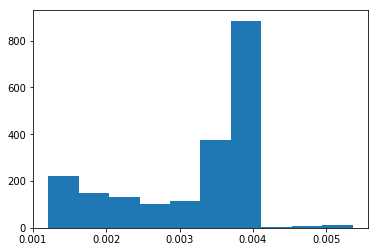

In [245]:
# Marginal effect scratch
delta = 0.01
me_vec = CE_1(Y, v_hat, v_hat + delta, 1/5) - CE_1(Y, v_hat, v_hat, 1/5)
plt.hist(me_vec)
np.mean(me_vec/delta)

# Actual Data

In [114]:
import pandas as pd

In [115]:
data_dmd = pd.read_csv(    '../data/processed/regression_data_levels_demeaned.csv')

In [195]:
# All
data_dmd_mat = np.matrix(data_dmd[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_mat[:,0]
X = data_dmd_mat[:,1:]

In [196]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.99))
result = minimize(obj_f, [3,1], method='BFGS')
result

      fun: 20.906169148161673
 hess_inv: array([[ 3180133.64785518, -9350943.64737649],
       [-9350943.64737649, 27495755.68591442]])
      jac: array([6.19888306e-06, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 18
     njev: 23
   status: 0
  success: True
        x: array([-106.06022496,  321.70285919])

In [182]:
# Rebate accepting
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [193]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.99))
result = minimize(obj_f, [2.5, 1], method='BFGS')
result

      fun: 1.592015117428438
 hess_inv: array([[ 1.78087223, -1.61035473],
       [-1.61035473,  4.17094113]])
      jac: array([-1.49011612e-08, -2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 3
     njev: 16
   status: 0
  success: True
        x: array([2.84147629, 0.14627105])

In [199]:
# Unpaid
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [200]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.99))
result = minimize(obj_f, [2.5, 1], method='BFGS')
result

      fun: 19.049982379437697
 hess_inv: array([[ 1.98560833e+07, -4.85987656e+07],
       [-4.85987656e+07,  1.18947937e+08]])
      jac: array([1.26361847e-05, 5.48362732e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 18
     njev: 91
   status: 2
  success: False
        x: array([-84.22797439, 213.29358613])